# Titanic 호 data 를 이용한 EDA 와 Feature Engineering 실습

Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  $\rightarrow$ 객실 등급  
survival -  Survival (0 = 사망; 1 = 생존)  $\rightarrow$ 생존여부  
name - Name  
sex - Sex  
age - Age  
sibsp - Number of Siblings/Spouses Aboard  $\rightarrow$ 함께 탑승한 형제 또는 배우자 수   
parch - Number of Parents/Children Aboard  $\rightarrow$ 함께 탑승한 부모 또는 자녀 수  
ticket - Ticket Number  
fare - Passenger Fare (British pound)  
cabin - Cabin  $\rightarrow$ 선실번호  
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  $\rightarrow$ 탑승한 항구(얼마나 부유한지와 관련)

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
df = pd.read_csv("datasets/titanic.csv")

In [3]:
df.shape

(891, 12)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- DataFrame의 정보 요약

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### numeric feature 의 기술 통계

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### categorical feature 의 통계

**object column 만 desribe**

In [7]:
df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",male,347082,G6,S
freq,1,577,7,4,644


### 생존자 비율 check


- 38.4 % 가 생존 (사망 - 0, 생존 - 1)

- explode는 부채꼴이 파이 차트의 중심에서 벗어나는 정도를 설정
- autopct는 부채꼴 안에 표시될 숫자의 형식을 지정

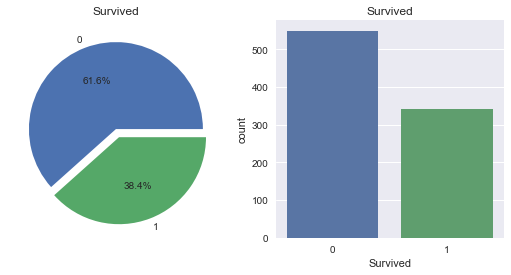

In [8]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

df['Survived'].value_counts() \
    .plot.pie(explode=[0,0.1], autopct='%1.1f%%', ax=ax1)

ax1.set_title('Survived')
ax1.set_ylabel('')
sns.countplot(x='Survived', data=df, ax=ax2)
ax2.set_title('Survived')
plt.show()

## outlier 검출

- outlier 가 prediction(특히 regression) 에 영향을 큰 영향을 줄 수 있으므로, 연속 값으로 구성된 column 의 outlier 검출

- outlier 의 정의는 일반적으로 `IQR(Inter-quartile range, Q3 - Q1) * 1.5` 보다 큰 경우로 한다.

-  세개 이상의 outlier 값을 가진 row 를 drop 시킨다.

In [9]:
THRESHOLD_OUTLIER = 3
outlier_indices = []

for col in ['Age', 'SibSp', 'Parch', 'Fare']:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1   
    outlier_step = IQR * 1.5
    outlier_list = \
        df[(df[col] < Q1 - outlier_step) | \
           (df[col] > Q3 + outlier_step)].index
    outlier_indices.extend(outlier_list)

In [10]:
len(outlier_indices)

375

In [11]:
outlier_indices[:10]

[7, 16, 24, 27, 50, 59, 63, 68, 71, 85]

- 동시에 여러개의 outlier 를 threshold 갯수 가진 sample 검출

In [12]:
from collections import Counter

multiple_outliers = \
list(k for k, v in Counter(outlier_indices).items() 
     if v >= THRESHOLD_OUTLIER)

multiple_outliers

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [13]:
df.iloc[multiple_outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


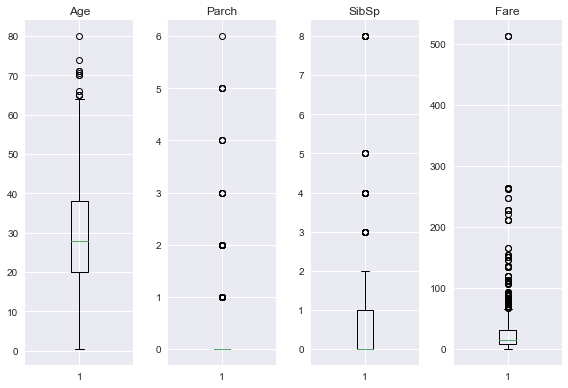

In [14]:
plt.subplot(141)
plt.boxplot(df[df['Age'] > 0]['Age'])
plt.title('Age')
plt.subplot(142)
plt.boxplot(df['Parch'])
plt.title('Parch')
plt.subplot(143)
plt.boxplot(df['SibSp'])
plt.title('SibSp')
plt.subplot(144)
plt.boxplot(df['Fare'])
plt.title('Fare')
plt.tight_layout()

In [15]:
df = df.drop(multiple_outliers).reset_index(drop=True)

In [16]:
df.shape

(881, 12)

## Feature type 별 분석
### Categorical features (Nominal Variable, 범주형 변수)
- Sex, Embarked

### Ordinal features (순위 변수)
- PClass

### Continuous feature (연속 변수)
- Age, Parch, Fare

### Discrete feature (이산 변수)
- SibSip

### Sex $\rightarrow$ Categorical features (Nominal Variable, 범주형 변수)

- 성별이 생존 여부에 미치는 상관관계 분석

In [17]:
df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            78
        1           231
male    0           463
        1           109
Name: Survived, dtype: int64

- `barplot`을 이용하여 성별 생존자 수 시각화. (사망 0, 생존 1 이므로 평균 == 비율)
- `countplot`을 이용하여 성별로 사망자/생존자 동시 시각화

Text(0.5, 1.0, 'By Sex: Dead(0) vs Survived(1)')

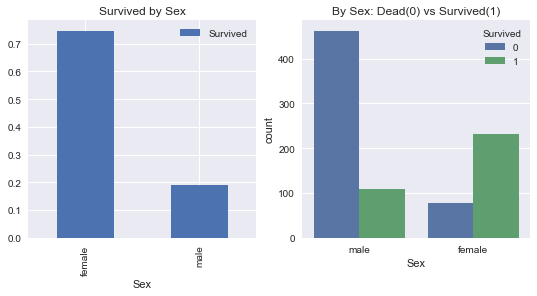

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
#성별 생존자수
df[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax1)
ax1.set_title('Survived by Sex')

#성별 사망자/생존자 수 비교
sns.countplot(x='Sex', hue='Survived', data=df, ax=ax2)
ax2.set_title('By Sex: Dead(0) vs Survived(1)')

- 성별은 생존 여부 판단에 매우 중요한 feature 임

### Pclass $\rightarrow$ Ordinal features (순위 변수) 

- 객실 등급과 생존 여부의 상관 관계 분석

In [19]:
df.groupby(['Pclass', 'Survived'])['Survived'].count()

Pclass  Survived
1       0            79
        1           134
2       0            97
        1            87
3       0           365
        1           119
Name: Survived, dtype: int64

- `barplot`을 이용하여 Pclass별 탑승자 수 시각화
- `countplot`을 이용하여 Pclass별로 사망자/생존자 동시 시각화

Text(0.5, 1.0, 'By Pclass: Dead(0) vs Survived(1)')

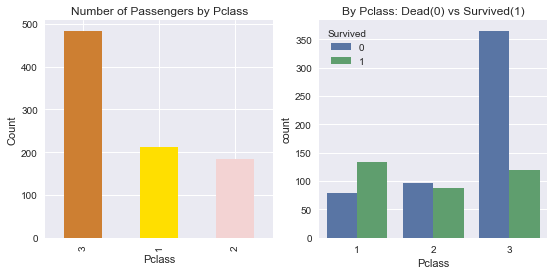

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

df['Pclass'].value_counts().\
        plot.bar(color=['#CD7F32','#FFDF00','#F3D3D3'], ax=ax1)
ax1.set_title('Number of Passengers by Pclass')
ax1.set_ylabel('Count')
ax1.set_xlabel('Pclass')

sns.countplot(x='Pclass', hue='Survived', data=df, ax=ax2)
ax2.set_title('By Pclass: Dead(0) vs Survived(1)')

`pd.crosstab`을 이용하여 `[df.Sex, df.Survived]`를 index로 하는 `Pclass` 빈도 table 작성  
- 성별, 생존여부의 Pclass 빈도 계산

In [21]:
pd.crosstab([df.Sex, df.Survived], df.Pclass, margins=True)

Pclass             1    2    3  All
Sex    Survived                    
female 0           3    6   69   78
       1          89   70   72  231
male   0          76   91  296  463
       1          45   17   47  109
All              213  184  484  881

- 객실 등급과 생존율의 상관 관계가 높으므로 ordinal feature 로 유지

### Age $\rightarrow$ Continuous feature (연속 변수)

- 나이과 생존 여부의 상관 관계 분석

In [22]:
print('최고령 - {}'.format(df['Age'].max()))
print('최연소 - {}'.format(df['Age'].min()))
print('평균 연령 - {:.2f}'.format(df['Age'].mean()))

최고령 - 80.0
최연소 - 0.42
평균 연령 - 29.73


- `violinplot`을 이용하여 객실 등급 및 성별 연령 분포 시각화 

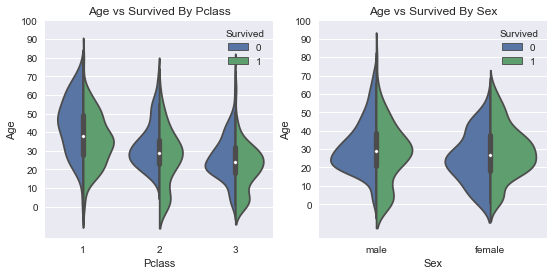

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=df, split=True, ax=ax1)
ax1.set_title('Age vs Survived By Pclass')
ax1.set_yticks(range(0, 110, 10))

sns.violinplot(x='Sex', y='Age', hue='Survived', data=df, split=True, ax=ax2)
ax2.set_title('Age vs Survived By Sex')
ax2.set_yticks(range(0, 110, 10));

- 객실 등급과 성별 모두 연령에 따라 생존여부 분포가 다르므로 연령은 생존 여부를 판단하기 좋은 특성으로 판단하여 연속 변수로 유지

### Embarked $\rightarrow$ Categoruical feature  

- 출발 항구와 생존 여부의 상관 관계 분석 

In [24]:
pd.crosstab(df.Embarked, df.Survived, margins=True)

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,419,215,634
All,541,338,879


- `catplot`을 이용하여 `Embarked` category별 생존율 시각화

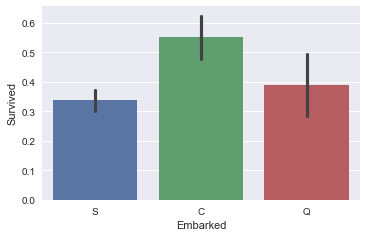

In [25]:
sns.catplot(x="Embarked", y="Survived", data=df, kind='bar')
fig = plt.gcf()
fig.set_size_inches(5, 3)

- `barplot`을 이용하여 `Embarked` 별 생존자 비율 시각화 (사망 0, 생존 1 이므로 평균 == 비율)
- `countplot`을 이용하여 성별로 사망자/생존자 동시 시각화

Text(0.5, 1.0, 'Survived vs Dead By Embarked')

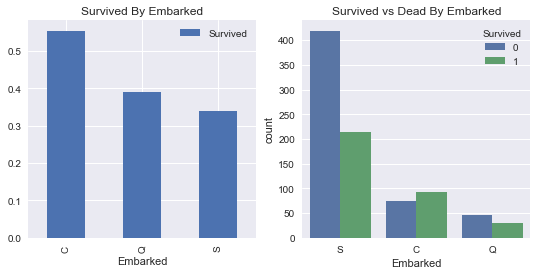

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
df[['Embarked', 'Survived']].groupby(['Embarked']).mean().plot.bar(ax=ax1)
ax1.set_title('Survived By Embarked')

sns.countplot(x='Embarked', hue='Survived', data=df, ax=ax2)
ax2.set_title('Survived vs Dead By Embarked')

- 출항 항구도 생존 여부와 상관 관계 있는 것으로 판단된다.

### SibSp $\rightarrow$ Discrete feature (이산 변수)

- SibSp 와 생존 여부의 상관 관계 분석

In [27]:
pd.crosstab(df.SibSp, df.Survived, margins=True)

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,11,2,13
4,15,3,18
5,5,0,5
All,541,340,881


- `barplot`을 이용하여 `SibSp` 별 생존자 비율 시각화 (사망 0, 생존 1 이므로 평균 == 비율)
- `countplot`을 이용하여 성별로 사망자/생존자 동시 시각화

Text(0.5, 1.0, 'Survived By SibSp')

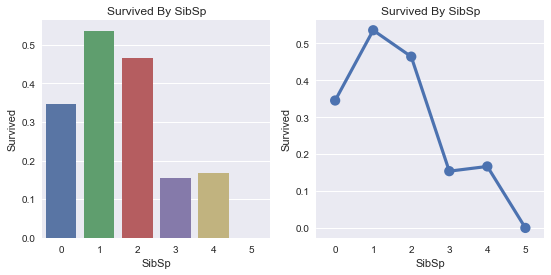

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sns.barplot(x='SibSp', y='Survived', data=df, ax=ax1, ci=None)
ax1.set_title('Survived By SibSp')

sns.pointplot(x='SibSp', y='Survived', data=df, ax=ax2, ci=None)
ax2.set_title('Survived By SibSp')

- `SibSp (동승한 배우자, 형제, 자매)` 수는 생존율과 상관 관계 있는 것으로 보인다.

### Parch : Parent Child 가 함께 승선한 자녀수

- Parch 와 Survival의 관계 분석

In [29]:
pd.crosstab(df.Parch, df.Survived)

Survived,0,1
Parch,,
0,445,233
1,53,65
2,32,38
3,2,3
4,4,0
5,4,1
6,1,0


Text(0.5, 1.0, 'Survived By Parent/Children')

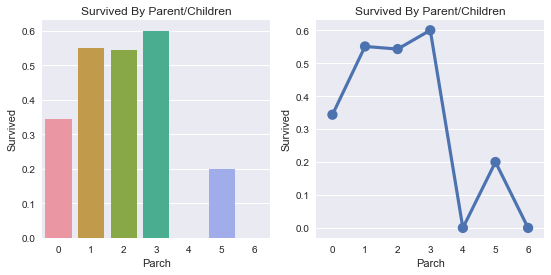

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sns.barplot(x='Parch', y='Survived', data=df, ax=ax1, ci=None)
ax1.set_title('Survived By Parent/Children')

sns.pointplot(x='Parch', y='Survived', data=df, ax=ax2, ci=None)
ax2.set_title('Survived By Parent/Children')

- 자녀수 1~3 의 생존율이 0 인 경우보다 높은 것으로 보이므로 생존 예측에 도움되는 feature로 판단

### Fare $\rightarrow$ Continuous feature

- Fare와 Pclass의 관계 분석

In [31]:
print('최고가:',df['Fare'].max())
print('최저가:',df['Fare'].min())
print('평균:',df['Fare'].mean())

최고가: 512.3292
최저가: 0.0
평균: 31.121565607264436


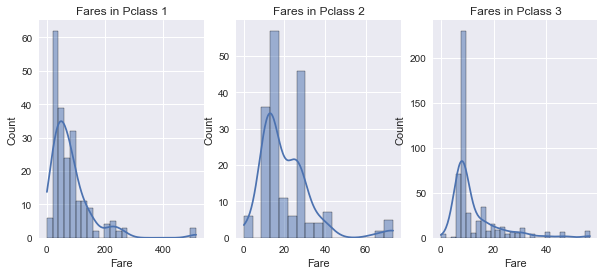

In [32]:
fig, ax = plt.subplots(1,3,figsize=(10,4))
sns.histplot(x=df[df['Pclass']==1].Fare,ax=ax[0], kde=True)
ax[0].set_title('Fares in Pclass 1')
sns.histplot(x=df[df['Pclass']==2].Fare,ax=ax[1], kde=True)
ax[1].set_title('Fares in Pclass 2')
sns.histplot(x=df[df['Pclass']==3].Fare,ax=ax[2], kde=True)
ax[2].set_title('Fares in Pclass 3');

- Pclass 와 Fare 간의 뚜렷한 상관 관계가 보임. Pclass 값이 작을 수록 Fare가 높다.

## Missing Value 처리

In [33]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

### Age missing value 처리

#### Name 안의 정보 추출

In [34]:
# 이름의 initial 추출
df['Initial'] = df.Name.str.extract('([A-Za-z]+)\.')

In [35]:
pd.crosstab(df.Initial, df.Sex).T

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,177,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,39,0,0,0,513,0,0,6,1


- Mr, Miss, Mrs, Master 로 범주화 한 후 category별 평균 나이 계산하여 Age 의 null value 채움

In [36]:
df.loc[(df.Initial != 'Mr') & (df.Initial != 'Mrs') & \
      (df.Initial != 'Miss') & (df.Initial != 'Master'), 'Initial'] = 'Others'

- `Initial`별로 평균 연령 계산

In [37]:
df.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.750000
Mr        32.401763
Mrs       35.898148
Others    42.384615
Name: Age, dtype: float64

- `Age` missing value를 `Initial`의 평균 나이로 채워줌

In [38]:
df.loc[(df.Age.isnull()) & (df.Initial == 'Mr'), 'Age'] = 32
df.loc[(df.Age.isnull()) & (df.Initial == 'Mrs'), 'Age'] = 36
df.loc[(df.Age.isnull()) & (df.Initial == 'Miss'), 'Age'] = 22
df.loc[(df.Age.isnull()) & (df.Initial == 'Master'), 'Age'] = 5
df.loc[(df.Age.isnull()) & (df.Initial == 'Master'), 'Age'] = 42

In [39]:
df.Age.isnull().sum()

1

- 남은 missing Age는 전체 Age의 평균으로 채움

In [40]:
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [41]:
df['Age'].isna().sum()

0

### Embarked null 처리
- 'S' 에서 승선한 사람이 가장 많으므로 Embarked 의 null 을 'S' 로 채움

In [42]:
df['Embarked'].isnull().sum()

2

In [43]:
df['Embarked'].fillna('S', inplace=True)
df['Embarked'].isnull().sum()

0

## Feature Engineering
### Age 
- Age 가 연속변수 이므로 Machine Learning model의 일반화를 위해 binning 을 통해 categorical value 로 convert
- 소년, 청년, 중년, 장년, 노년으로 구분

In [44]:
df['Age_band'] = 0
df.loc[df.Age <= 16, 'Age_band'] = 0
df.loc[(df.Age > 16) & (df.Age <= 32), 'Age_band'] = 1
df.loc[(df.Age > 32) & (df.Age <= 48), 'Age_band'] = 2
df.loc[(df.Age > 48) & (df.Age <= 64), 'Age_band'] = 3
df.loc[df.Age > 64, 'Age_band'] = 4
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2


### Family_Size 
- Parch + SibSp 로 새로운 Famili_Size 변수 생성

### Alone
- Family_Size 가 0 면 Alone 변수에 1 assign

In [45]:
df['Family_size'] = df.Parch + df.SibSp
df['Alone'] = 0
df.loc[df.Family_size == 0, 'Alone'] = 1
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Family_size,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2,0,1


<AxesSubplot:xlabel='Alone', ylabel='Survived'>

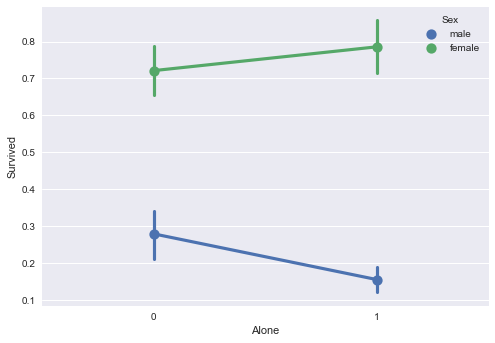

In [46]:
sns.pointplot(x='Alone', y='Survived', hue='Sex', col='Pclass', data=df)

- 새로이 생성한 `Alone` feature는 생존 여부 판단에 도움이 되는 것으로 보인다.

### Fare_Range Binning
- Fare 역시 연속변수 이므로 pandas.qcut 함수를 이용하여 category 변수로 convert 
- 4분위 구간으로 binning

In [47]:
df['Fare_Range'] = pd.qcut(df.Fare, 4)  # 4분위수로 구간 나누기
df.groupby('Fare_Range').Survived.mean().to_frame()

,Survived
Fare_Range,
"(-0.001, 7.896]",0.197309
"(7.896, 14.454]",0.303571
"(14.454, 30.5]",0.456221
"(30.5, 512.329]",0.594470


In [48]:
df['Fare_cat'] = 0
df.loc[df.Fare <= 7.91, 'Fare_cat'] = 0
df.loc[(df.Fare > 7.91) & (df.Fare <= 14.454), 'Fare_cat'] = 1
df.loc[(df.Fare > 14.454) & (df.Fare <= 31), 'Fare_cat'] = 2
df.loc[(df.Fare > 31) & (df.Age <= 513), 'Fare_cat'] = 3
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band,Family_size,Alone,Fare_Range,Fare_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,1,0,"(-0.001, 7.896]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,1,0,"(30.5, 512.329]",3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,1,"(7.896, 14.454]",1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,1,0,"(30.5, 512.329]",3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,2,0,1,"(7.896, 14.454]",1


<AxesSubplot:xlabel='Fare_cat', ylabel='Survived'>

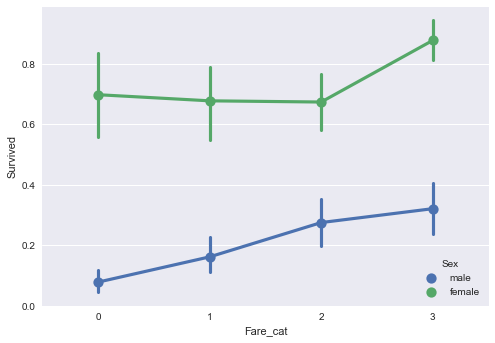

In [49]:
sns.pointplot(x='Fare_cat', y='Survived', data=df, hue='Sex')

### 불필요한 field drop

- `Age -> Age_band`, `Fare/Fare_Rage -> Fare_cat` 으로 구간화 하였으므로 drop  
- 생존 여부 판단에 불필요한 `Name`, `Ticker`, `Cabin` drop 

In [50]:
df.drop(['Name','Age', 'Ticket','Fare', 'Cabin', 
         'Fare_Range', 'PassengerId'], axis=1, inplace=True)

In [51]:
df.head(3)

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_size,Alone,Fare_cat
0,0,3,male,1,0,S,Mr,1,1,0,0
1,1,1,female,1,0,C,Mrs,2,1,0,3
2,1,3,female,0,0,S,Miss,1,0,1,1


## Feature 들 간의 Correlation

- Survived 와 각 Feature 간 상관관계 파악

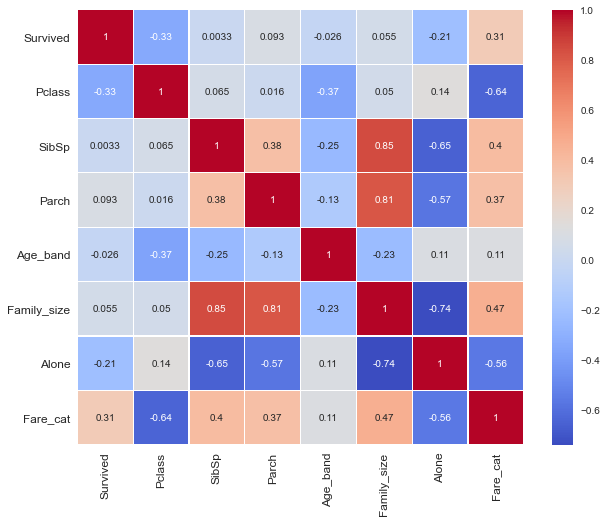

In [52]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidth=0.2, annot_kws={'size': 10})
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

가장 상관 관계가 높은 feature 는 Fare-cut 이고 Pclass 는 가장 상관관계가 반대인 것으로 나타난다.

### One-Hot-Encoding 

- Category 변수의 one-hot-encoding

In [53]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,SibSp,Parch,Age_band,Family_size,Alone,Fare_cat,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Initial_Master,Initial_Miss,Initial_Mr,Initial_Mrs,Initial_Others
0,0,3,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0
1,1,1,1,0,2,1,0,3,1,0,1,0,0,0,0,0,1,0
2,1,3,0,0,1,0,1,1,1,0,0,0,1,0,1,0,0,0
3,1,1,1,0,2,1,0,3,1,0,0,0,1,0,0,0,1,0
4,0,3,0,0,2,0,1,1,0,1,0,0,1,0,0,1,0,0


## Train / Test dataset split

In [54]:
X = df[df.columns[1:]]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((704, 17), (177, 17), (704,), (177,))

## Standard Scaling

In [55]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## Modeling 

- 다양한 모델을 적용하고 ROC-AUC를 이용해 best model 선택

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

n_fold = 10

### SVC

In [57]:
sv = SVC(kernel='rbf', C=1, gamma=0.1)
sv.fit(X_train, y_train)
pred_sv = sv.predict(X_test)
print('Accuracy for rbf SVM is', accuracy_score(pred_sv, y_test))

Accuracy for rbf SVM is 0.847457627118644


### Logistic Regression

In [70]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict_proba(X_test)
print('Accuracy for Logistic Regression is', accuracy_score(pred_lr[:, 1] > 0.5, y_test))

Accuracy for Logistic Regression is 0.8361581920903954


### KNN

- 시각화를 통해 최적의 K 값 선택

Accuracies =  [0.83050847 0.8079096  0.84745763 0.83615819 0.82485876 0.84745763
 0.84745763 0.84745763 0.83615819 0.83615819] 
max accuracy k =  3


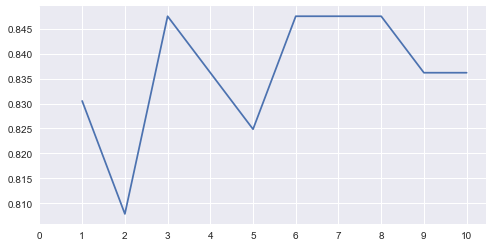

In [59]:
fig = plt.figure(figsize=(8, 4))

a_index = list(range(1, 11))
a = pd.Series(dtype=np.float32)
for i in a_index:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    a = a.append(pd.Series(accuracy_score(prediction, y_test)))
plt.plot(a_index, a)
plt.xticks(range(11));
print('Accuracies = ', a.values, '\nmax accuracy k = ', a.values.argmax()+1)

In [72]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred_knn = knn.predict_proba(X_test)
print('Accuracy for KNN is', accuracy_score(pred_knn[:,1]>0.5, y_test))

Accuracy for KNN is 0.847457627118644


### Random Forest

Accuracies =  [0.85875706 0.86440678 0.85875706 0.85875706 0.85875706 0.85310734] 
max accuracy k =  2


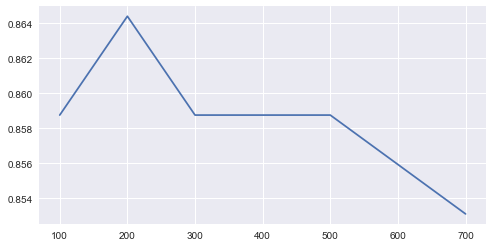

In [61]:
fig = plt.figure(figsize=(8, 4))

a_index = [100, 200, 300, 400, 500, 700]
a = pd.Series(dtype=np.float32)
for i in a_index:
    model = RandomForestClassifier(n_estimators=i, random_state=21)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    a = a.append(pd.Series(accuracy_score(prediction, y_test)))
plt.plot(a_index, a)
print('Accuracies = ', a.values, '\nmax accuracy k = ', a.values.argmax()+1)

In [73]:
rf = RandomForestClassifier(n_estimators=200, random_state=21)
rf.fit(X_train, y_train)
pred_rf = rf.predict_proba(X_test)
print('Accuracy for Random Forest is', accuracy_score(pred_rf[:,1]>0.5, y_test))

Accuracy for Random Forest is 0.864406779661017


In [75]:
roc_curve?

In [77]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score
from sklearn.metrics import  roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

fpr_sv, tpr_sv, _ = roc_curve(y_test, pred_sv)
auc_sv         = roc_auc_score(y_test, pred_sv)

fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_lr[:, 1])
auc_lr         = roc_auc_score(y_test, pred_lr[:, 1])

fpr_knn, tpr_knn, _ = roc_curve(y_test, pred_knn[:, 1])
auc_knn         = roc_auc_score(y_test, pred_knn[:, 1])

fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf[:, 1])
auc_rf         = roc_auc_score(y_test, pred_rf[:, 1])

Text(0.5, 1.0, 'ROC Curve')

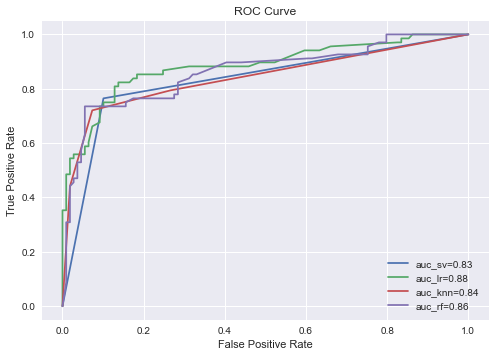

In [78]:
plt.plot(fpr_sv, tpr_sv, label="auc_sv=" + "{:.2f}".format(auc_sv))
plt.plot(fpr_lr, tpr_lr, label="auc_lr=" + "{:.2f}".format(auc_lr))
plt.plot(fpr_knn, tpr_knn, label="auc_knn=" + "{:.2f}".format(auc_knn))
plt.plot(fpr_rf, tpr_rf, label="auc_rf=" + "{:.2f}".format(auc_rf))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

- LogisticRegression model이 가장 우수한 것으로 나타남

Text(0.5, 1.0, 'Random Forest')

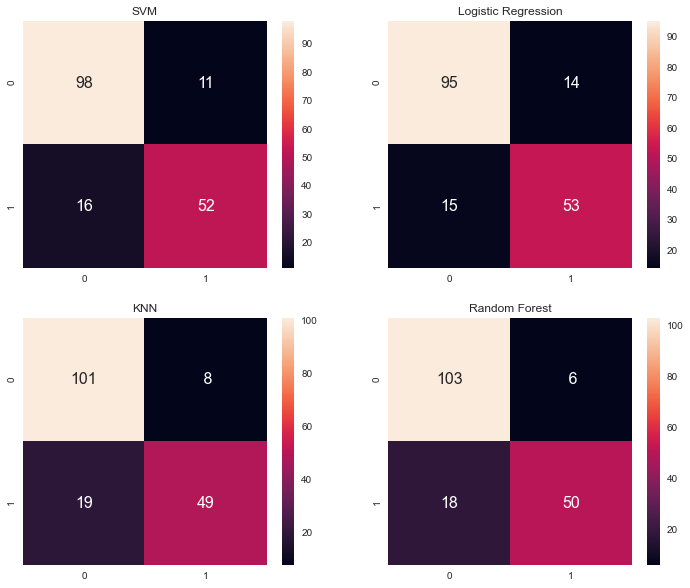

In [80]:
f, ax = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(confusion_matrix(y_test, pred_sv), 
            ax=ax[0,0], annot=True, fmt='2.0f', annot_kws={'size':16})
ax[0,0].set_title('SVM')
sns.heatmap(confusion_matrix(y_test, pred_lr[:,1]>0.5), 
            ax=ax[0,1], annot=True, fmt='2.0f', annot_kws={'size':16})
ax[0,1].set_title('Logistic Regression')
sns.heatmap(confusion_matrix(y_test, pred_knn[:,1]>0.5), 
            ax=ax[1,0], annot=True, fmt='2.0f', annot_kws={'size':16})
ax[1,0].set_title('KNN')
sns.heatmap(confusion_matrix(y_test, pred_rf[:,1]>0.5), 
            ax=ax[1,1], annot=True, fmt='2.0f', annot_kws={'size':16})
ax[1,1].set_title('Random Forest')

### Random Forest의 Feature Importance 시각화

- RandomForest는 white-box model이므로 feature importance를 시각화할 수 있다.

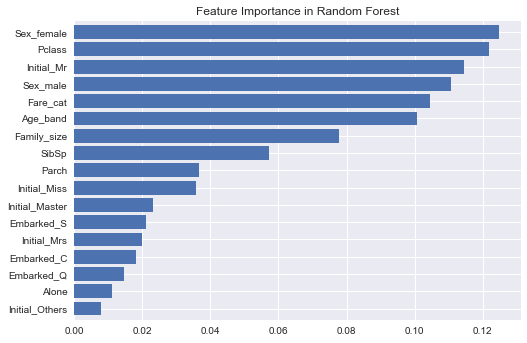

In [82]:
pd.Series(rf.feature_importances_, X.columns).\
            sort_values(ascending=True).plot.barh(width=0.8)
plt.title("Feature Importance in Random Forest")
plt.show()